<a href="https://colab.research.google.com/github/juliuserbach/Semantic-Features/blob/master/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ftaubner/semantic_features_detection.git

Cloning into 'semantic_features_detection'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1260 (delta 142), reused 114 (delta 51), pack-reused 1017
Receiving objects: 100% (1260/1260), 113.91 MiB | 39.82 MiB/s, done.
Resolving deltas: 100% (748/748), done.


In [2]:
!wget --no-check-certificate "https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%2199865&authkey=ALxjJOloi9Wjk80" -O mapillary_vistas_sample.zip

--2020-04-04 20:09:19--  https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%2199865&authkey=ALxjJOloi9Wjk80
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yijzyw.am.files.1drv.com/y4m50EQFlyWO7vTqPaY0X2gDyf6LLzvM_MDqc_h-Yz8g81mLUWMmg1p3ylQ6eSLJmVogra50Kvl4V9Ud-1KJht52uPBkNmbMVG666hBj4V05l9Jnkts9WdeMrOyvYb08dnrN0PU7V3OKrv7GqyxNymlE3sB-4PXVbu8WIUm3CRO3EjpXeB4W0QrLaIpfvQTxe8tH9Rc4opINlyT3KDZh_1Zig/mapillary_vistas_sample.zip?download&psid=1 [following]
--2020-04-04 20:09:20--  https://yijzyw.am.files.1drv.com/y4m50EQFlyWO7vTqPaY0X2gDyf6LLzvM_MDqc_h-Yz8g81mLUWMmg1p3ylQ6eSLJmVogra50Kvl4V9Ud-1KJht52uPBkNmbMVG666hBj4V05l9Jnkts9WdeMrOyvYb08dnrN0PU7V3OKrv7GqyxNymlE3sB-4PXVbu8WIUm3CRO3EjpXeB4W0QrLaIpfvQTxe8tH9Rc4opINlyT3KDZh_1Zig/mapillary_vistas_sample.zip?download&psid=1
Resolving yijzyw.am.files.1dr

In [0]:
!unzip -qq /content/mapillary_vistas_sample.zip -d /content

In [4]:
!pip install imgaug
!pip install Cython
!pip install pycocotools

In [0]:
import os
os.chdir('/content/semantic_features_detection/Notebook')

In [6]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
%tensorflow_version 1.x
import tensorflow as tf


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/mapillary/"))  # To find local version
import mapillary

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

TensorFlow 1.x selected.
/content/semantic_features_detection


Using TensorFlow backend.


... done downloading pretrained model!
/content/semantic_features_detection/logs
... done downloading pretrained model!
finished


In [7]:
class_names= ['Unlabeled', 'Bird', 'Ground Animal', 'Curb', 'Fence', 'Guard Rail', 
              'Barrier', 'Wall', 'Bike Lane', 'Crosswalk - Plain', 'Curb Cut', 'Parking', 
              'Pedestrian Area', 'Rail Track', 'Road', 'Service Lane', 'Sidewalk', 'Bridge', 
              'Building', 'Tunnel', 'Person', 'Bicyclist', 'Motorcyclist', 'Other Rider', 
              'Lane Marking - Crosswalk', 'Lane Marking - General', 'Mountain', 'Sand', 
              'Sky', 'Snow', 'Terrain', 'Vegetation', 'Water', 'Banner', 'Bench', 'Bike Rack',
              'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox',
              'Manhole', 'Phone Booth', 'Pothole', 'Street Light', 'Pole', 'Traffic Sign Frame', 
              'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)',
              'Trash Can', 'Bicycle', 'Boat', 'Bus', 'Car', 'Caravan', 'Motorcycle', 'On Rails',
              'Other Vehicle', 'Trailer', 'Truck', 'Wheeled Slow', 'Car Mount', 'Ego Vehicle']
selected_classes = [34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52]
print(selected_classes)

[34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52]


In [0]:
TRAIN_DIR = '/content/mapillary_vistas'
# Training dataset
dataset_train = mapillary.MapillaryDataset()
dataset_train.load_vistas(dataset_dir=TRAIN_DIR, subset='training', class_ids=selected_classes)
dataset_train.prepare()

# Validation dataset
VAL_DIR = '/content/mapillary_vistas'

dataset_val = mapillary.MapillaryDataset()
dataset_val.load_vistas(dataset_dir=VAL_DIR, subset='validation', class_ids=selected_classes)
dataset_val.prepare()

['BG', 'Bench', 'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox', 'Manhole', 'Phone Booth', 'Street Light', 'Pole', 'Traffic Sign Frame', 'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)', 'Trash Can']


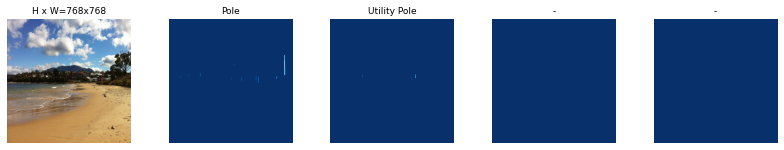

['BG', 'Bench', 'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox', 'Manhole', 'Phone Booth', 'Street Light', 'Pole', 'Traffic Sign Frame', 'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)', 'Trash Can']


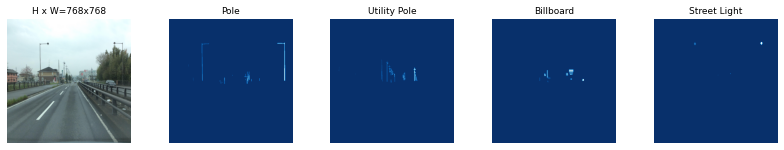

['BG', 'Bench', 'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox', 'Manhole', 'Phone Booth', 'Street Light', 'Pole', 'Traffic Sign Frame', 'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)', 'Trash Can']


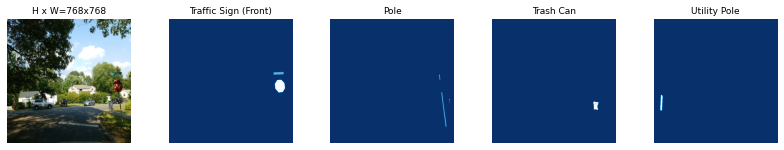

['BG', 'Bench', 'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox', 'Manhole', 'Phone Booth', 'Street Light', 'Pole', 'Traffic Sign Frame', 'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)', 'Trash Can']


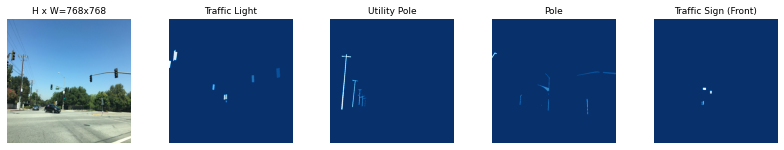

In [14]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(dataset_train.class_names)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names[1:])

In [10]:
class TrainConfig(mapillary.mapvistas):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 10
    NUM_CLASSES = len(selected_classes) + 1
config = TrainConfig()
config.display()
batch_size = config.BATCH_SIZE


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                30
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
#model.load_weights(model_path, by_name=True)

# Load pretrained weights
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=MODEL_DIR, histogram_freq=1)

In [13]:
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='heads', custom_callbacks = [tensorboard_callback])

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/semantic_features_detection/logs/mapvistas20200404T2010/mask_rcnn_mapvistas_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_m

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


TypeError: ignored

In [0]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers='4+')



In [0]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160,
            layers='all')